In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

Number of rows with missing values: 0.0


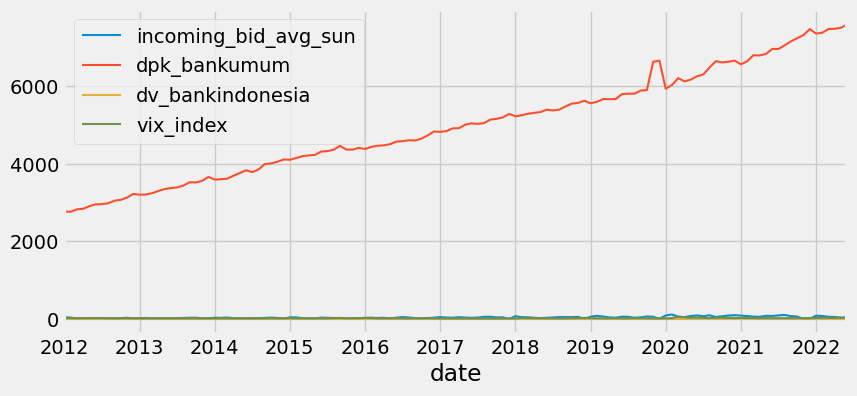

In [28]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/arifpras/forecastingDemand/main/20230126_database.csv')
data = pd.read_csv(url, sep=',', header=0, names=['month', 'incoming_bid_avg_sun', 'incoming_bid_avg_sbn', 'dpk_bankumum', 'dv_bankindonesia', 'vix_index', 'bfcius_bberg'])

# Data preparation
# ==============================================================================
data = data.rename(columns={'month': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'incoming_bid_avg_sun': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='incoming_bid_avg_sun')
data['dpk_bankumum'].plot(ax=ax, label='dpk_bankumum')
data['dv_bankindonesia'].plot(ax=ax, label='dv_bankindonesia')
data['vix_index'].plot(ax=ax, label='vix_index')
ax.legend();

In [29]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [ ]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

In [30]:
# Split data into train-test
# ==============================================================================
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2012-01-01 00:00:00 --- 2021-06-01 00:00:00  (n=114)
Test dates  : 2021-07-01 00:00:00 --- 2022-06-01 00:00:00  (n=12)


In [32]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train[['dpk_bankumum', 'dv_bankindonesia', 'vix_index']])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['dpk_bankumum', 'dv_bankindonesia', 'vix_index'] 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2021-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-27 21:00:06 
Last fit date: 2023-01-27 21:00:06 
Skforeca

In [33]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test[['dpk_bankumum', 'dv_bankindonesia', 'vix_index']])

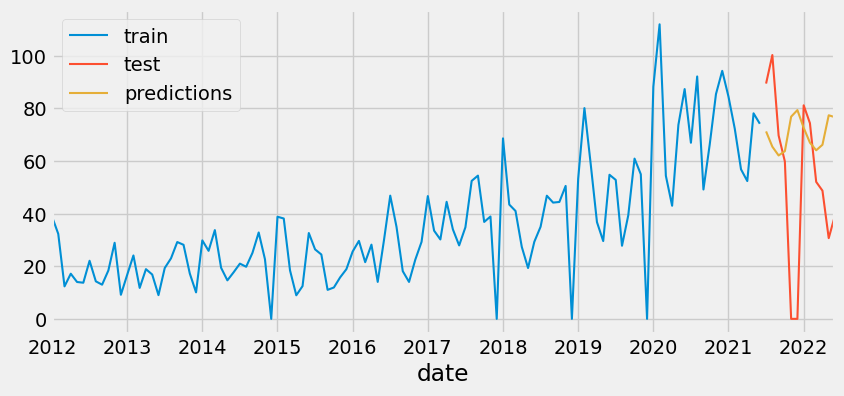

In [34]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [35]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1499.4317148552846


In [37]:
# Hyperparameter Grid search
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    exog        = data_train[['dpk_bankumum', 'dv_bankindonesia', 'vix_index']],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 27.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:19<00:00,  6.56s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 452.9525582629103



In [38]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",452.952558,10,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 100}",453.999123,10,100
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",461.112844,5,50
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",462.117106,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 100}",467.765071,3,100


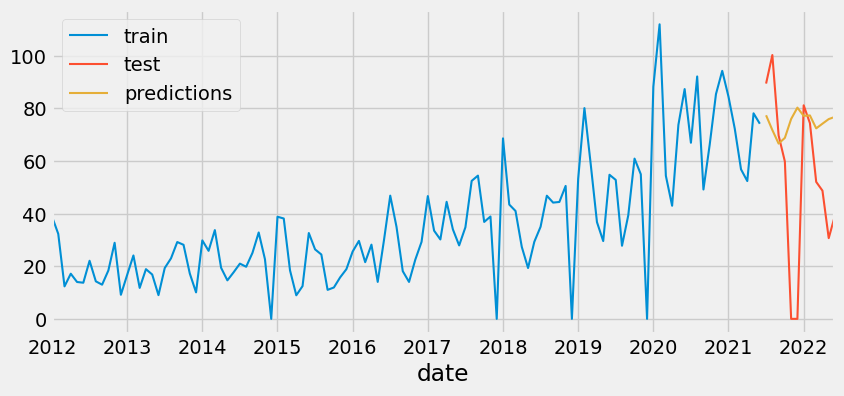

In [41]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test[['dpk_bankumum', 'dv_bankindonesia', 'vix_index']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [42]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 1485.231324110687
